# Transfer Learning

Transfer learning constitutes a fundamental paradigm in modern deep learning that enables
the reuse of knowledge acquired by a model during training on a large-scale dataset to
solve a different but related task. Rather than initializing a neural network with random
weights and training it from scratch, transfer learning leverages the internal
representations previously learned by a model trained on extensive and diverse datasets
such as ImageNet, which contains millions of labeled images spanning thousands of
categories. These learned representations encode hierarchical visual patterns ranging
from low-level features such as edges, corners, and textures in the initial layers, to
increasingly abstract and complex compositions such as object parts and semantic
structures in the deeper layers. By transferring this knowledge to a new task, the
approach significantly reduces the amount of labeled data required, accelerates
convergence during training, and typically achieves superior performance compared to
training from scratch, particularly when the target dataset is limited in size. The
underlying assumption is that the features learned from a large and generic dataset
capture general visual properties that remain useful across different but related
domains, requiring only specialization of the final layers to adapt to the specific
characteristics of the new task.

## Fundamental Strategies in Transfer Learning

The practical application of transfer learning is organized around three principal
strategies that differ in the extent to which the pretrained model parameters are updated
during training on the target task. The selection of an appropriate strategy depends
primarily on two factors: The size of the available target dataset and the degree of
similarity between the source domain (the dataset on which the model was originally
trained) and the target domain (the new task to be solved). These strategies are feature
extraction, partial fine-tuning, and full fine-tuning, each offering distinct trade-offs
between computational efficiency, risk of overfitting, and capacity for domain
adaptation.

In the feature extraction strategy, all parameters of the pretrained convolutional base
are frozen, meaning their values remain fixed and are not updated during training. Only
the final classification layer, which is replaced to match the number of classes in the
target task, is trained from scratch. In this configuration, the pretrained network
functions as a fixed feature extractor that transforms input images into high-dimensional
feature vectors, and a lightweight classifier is trained on top of these representations
to perform the specific classification task. This approach is particularly suitable when
the target dataset is very small, typically containing fewer than approximately one
thousand images, and when the visual domain of the target task is relatively similar to
that of the pretraining dataset, such as natural scenes, everyday objects, or common
textures. The primary advantage of feature extraction is computational efficiency and
reduced risk of overfitting, since the vast majority of parameters remain fixed and only
a small number of weights in the final layer are optimized. However, the limitation of
this strategy is its reduced capacity to adapt to domains that differ substantially from
the pretraining data, because the internal feature representations cannot be modified to
capture domain-specific patterns.

In [1]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

In the partial fine-tuning strategy, the earliest layers of the network, which are
closest to the input and capture low-level visual features, are kept frozen, while
several of the deeper convolutional layers, together with the final classification layer,
are unfrozen and updated during training. The rationale behind this approach is that the
initial layers of a convolutional network learn generic features such as edges,
gradients, and simple textures that are broadly applicable across different visual
domains, whereas the deeper layers encode more task-specific and abstract
representations. By freezing the early layers and fine-tuning only the later ones, the
model preserves the general-purpose features while adapting the high-level
representations to the characteristics of the new task. This strategy is appropriate for
medium-sized datasets, typically ranging from one thousand to ten thousand images, and
when the target domain is moderately different from the source domain. An illustrative
example is medical image analysis, where the images may exhibit different visual
characteristics compared to natural images, such as specific anatomical structures or
imaging modalities, but still share certain fundamental visual patterns such as textures,
shapes, and spatial relationships. Partial fine-tuning offers a balanced compromise
between flexibility and protection against overfitting, as only a subset of the network
parameters is modified. Additionally, it is common practice to employ differentiated
learning rates, assigning a lower learning rate to the pretrained layers being fine-tuned
and a higher learning rate to the newly initialized classification layer, thereby
preventing abrupt changes to the pretrained weights while allowing the new layer to adapt
more rapidly.

In [2]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

optimizer = torch.optim.Adam([
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3}
])

In the full fine-tuning strategy, all parameters of the pretrained model, including both
the convolutional base and the classification layer, are updated during training on the
target task. This approach aims to adapt the entire network architecture to the new
domain while preserving the beneficial initialization provided by the pretrained weights,
thereby avoiding the phenomenon known as catastrophic forgetting, in which the knowledge
acquired during pretraining is abruptly destroyed. To mitigate this risk, full
fine-tuning is typically performed using a relatively low learning rate, which allows
gradual adaptation of the weights without causing drastic changes that would eliminate
the useful representations learned during pretraining. This strategy is recommended when
a large target dataset is available, typically containing more than ten thousand images,
or when the target domain differs significantly from the source domain, such as highly
specialized medical imaging modalities, satellite or aerial imagery, industrial
inspection images, or any other domain with distinctive visual characteristics not well
represented in standard pretraining datasets. Although full fine-tuning entails higher
computational cost and increased risk of overfitting if the dataset is insufficient, it
generally provides the highest achievable performance, as the entire network architecture
is optimized to capture the specific patterns and structures present in the target task.

In [3]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Complete Practical Example with CIFAR-10

The following section presents a complete and executable workflow that demonstrates the
application of transfer learning using the feature extraction strategy on the CIFAR-10
dataset. CIFAR-10 is a widely used benchmark dataset consisting of 60,000 color images of
size $32 \times 32$ pixels, divided into 10 classes representing common objects such as
airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. For
the purpose of this example, the task is simplified to binary classification by selecting
only two classes from the dataset. The workflow encompasses all essential steps,
including data preparation with appropriate transformations, model configuration using a
pretrained ResNet-18 architecture, training loop implementation, and evaluation of the
trained model. The code is designed to be fully functional and executable, providing a
practical template that can be adapted to other classification tasks.

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

selected_classes = [3, 5]
train_indices = [i for i, (_, label) in enumerate(train_dataset_full) if label in selected_classes]
test_indices = [i for i, (_, label) in enumerate(test_dataset_full) if label in selected_classes]

train_indices = train_indices[:1000]
test_indices = test_indices[:200]

train_dataset = Subset(train_dataset_full, train_indices)
test_dataset = Subset(test_dataset_full, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/dani/Repositorios/unie-deep-learning/.venv/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


The data preparation phase involves defining appropriate image transformations that
ensure compatibility with the pretrained model. The images are resized to
$224 \times 224$ pixels, which is the standard input size for ResNet architectures,
converted to tensors, and normalized using the mean and standard deviation values
computed on the ImageNet dataset. This normalization is critical because the pretrained
model was trained with these specific statistics, and applying the same normalization to
the target data ensures that the input distribution matches the distribution the model
expects. The CIFAR-10 dataset is loaded using the torchvision datasets module, and a
binary classification task is created by selecting two classes (cats and dogs,
corresponding to class indices 3 and 5). The dataset is filtered to retain only samples
belonging to these two classes, and separate data loaders are created for training and
testing.

In [5]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

The model configuration follows the feature extraction strategy. A ResNet-18 architecture
pretrained on ImageNet is loaded, and all parameters in the convolutional base are frozen
by setting requires_grad to False. The final fully connected layer is replaced with a new
linear layer that outputs two logits corresponding to the two classes in the binary
classification task. Only the parameters of this new layer are trainable, and the model
is transferred to the appropriate device (GPU if available, otherwise CPU). The loss
function is cross-entropy loss, which is standard for multi-class classification tasks,
and the optimizer is Adam with a learning rate of $10^{-3}$.

In [6]:
from tqdm import tqdm

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Add tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        labels = torch.tensor([selected_classes.index(label.item()) for label in labels], device=device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar with current metrics
        pbar.set_postfix({
            'loss': f'{running_loss/total:.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

Epoch 1/1: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s, loss=0.0202, acc=65.40%]

Epoch [1/1], Loss: 0.6326, Accuracy: 65.40%


The training loop iterates over the specified number of epochs, and for each epoch, the
model processes all batches in the training dataset. The labels are remapped to binary
indices (0 and 1) to match the output dimension of the modified classification layer. For
each batch, the gradients are zeroed, the forward pass computes the model outputs, the
loss is calculated, the backward pass computes the gradients, and the optimizer updates
the trainable parameters. Training loss and accuracy are tracked and displayed at the end
of each epoch to monitor the learning progress.

In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = torch.tensor([selected_classes.index(label.item()) for label in labels], device=device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 77.50%


After training, the model is evaluated on the test dataset to assess its generalization
performance. The model is set to evaluation mode, which disables dropout and batch
normalization updates, and predictions are generated for all test samples without
computing gradients. The test accuracy is calculated as the percentage of correctly
classified samples and provides an estimate of the model's performance on unseen data.
This complete workflow demonstrates how transfer learning enables effective training on a
small dataset by leveraging pretrained representations, achieving reasonable performance
with minimal computational resources and training time.

## Embedding Extraction

Embeddings are high-dimensional numerical vectors that provide a compact and semantically
meaningful representation of the input data. In the context of computer vision, an
embedding captures the essential visual characteristics of an image in a fixed-length
vector, typically extracted from one of the intermediate or final layers of a trained
convolutional neural network. These representations are particularly valuable because
they encode learned features that reflect the semantic content of the image, enabling
their use in tasks such as similarity search, clustering, visualization, and retrieval.
By removing the final classification layer from a pretrained model and extracting the
output of the preceding layer, one obtains a feature vector that summarizes the image
content in a form that is both discriminative and generalizable across different tasks.

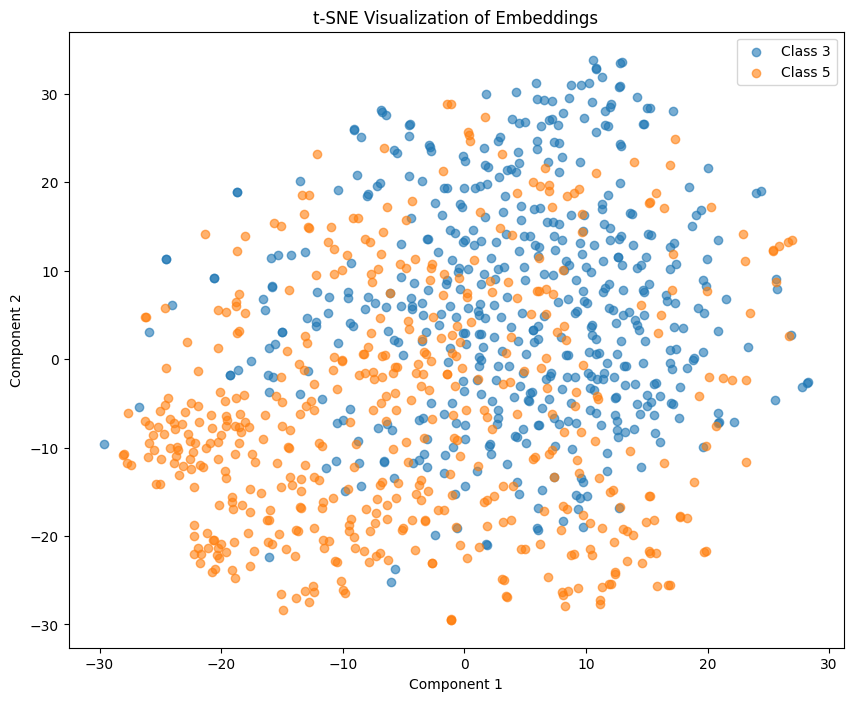

In [9]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = nn.Sequential(*list(model.children())[:-1])
model.eval()

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_embeddings(dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            emb = model(images).squeeze()
            embeddings.append(emb.numpy())
            labels.append(lbls.numpy())
    return np.vstack(embeddings), np.concatenate(labels)

embeddings, labels = extract_embeddings(train_loader)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=f'Class {label}', alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

The extraction of embeddings involves modifying the pretrained model by removing the
final classification layer, thereby retaining only the convolutional base and the global
average pooling layer. For ResNet-18, this results in a 512-dimensional feature vector
for each input image. The model is set to evaluation mode to ensure consistent behavior,
and the same preprocessing transformations used during training are applied to the input
image. The extract_embedding function takes an image file path as input, loads and
preprocesses the image, passes it through the modified model, and returns the resulting
embedding as a NumPy array. These embeddings can subsequently be used for various
downstream applications, such as computing pairwise similarities using cosine distance or
Euclidean distance, performing dimensionality reduction for visualization using
techniques such as t-SNE or UMAP, or training classifiers on top of the extracted
features for new tasks without requiring access to the original training data or
computational resources for full model training.